### Using transfer learning to recognize dog breeds (VGG16)

In [1]:
import os
import sys
import time
import pickle

from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np

from functools import partial

from multiprocessing import Pool

from skimage import io
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras 
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16

from script.image import load_train_resized

import matplotlib
import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
labels_df = pd.read_csv('labels.csv')
print(labels_df.shape)

(10222, 2)


Load images on multiple threads, the loading method has to be defined outside the notebook or it does not work.  
It also scales images to (224, 224, 3) as the VGG16 model expects.  

In [3]:
def load_images(folder, names, h, w):
    load_image = partial(load_train_resized, folder=folder, h=h, w=w)
    
    with Pool(6) as p:
        rs = p.map_async(load_image, names)
        p.close()
        while (True):
            if (rs.ready()): break
            remaining = rs._number_left
            print("Waiting for", remaining, "tasks to complete...")
            time.sleep(10)
    print('Finished loading images...')
    
    images = []
    for r in rs.get():
        images.append(r)
    return np.asarray(images)

In [4]:
train_ids = list(labels_df.id)
train_features = load_images('train', train_ids, 224, 224)
print('Features shape ', train_features.shape)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 12 tasks to complete...
Waiting for 6 tasks to complete...
Finished loading images...
Features shape  (10222, 224, 224, 3)


In [5]:
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(labels_df.breed)
print('Labels shape ', labels.shape)

Labels shape  (10222, 120)


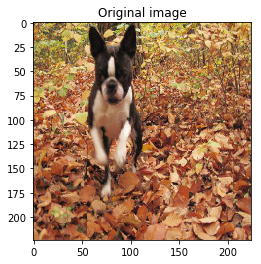

In [6]:
plt.imshow(train_features[0])
plt.title('Original image')

In [7]:
train_features_mean = np.mean(train_features, axis=(0))
print(train_features_mean.shape)

(224, 224, 3)


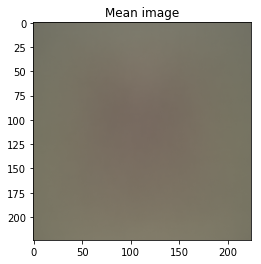

In [8]:
plt.imshow(train_features_mean)
plt.title('Mean image')

In [9]:
train_features_centered = train_features - train_features_mean

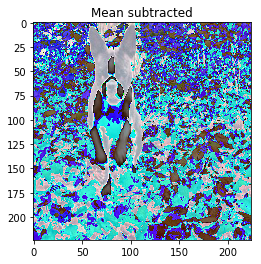

In [10]:
plt.imshow(train_features_centered[0])
plt.title('Mean subtracted')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    train_features_centered, labels, test_size=0.10, stratify = labels_df.breed, random_state = 442)

In [12]:
print('Train label matrix shape:', y_train.shape)
print('Train predictor matrix shape:', X_train.shape)
print('Test label matrix shape:', y_test.shape)
print('Test predictor matrix shape:', X_test.shape)

Train label matrix shape: (9199, 120)
Train predictor matrix shape: (9199, 224, 224, 3)
Test label matrix shape: (1023, 120)
Test predictor matrix shape: (1023, 224, 224, 3)


To start with lets use the original images

In [13]:
train_datagen = ImageDataGenerator()
train_datagen.fit(X_train)

In [14]:
test_datagen = ImageDataGenerator()
test_datagen.fit(X_test)

#### Pre-trained VGG16 model.

In [13]:
vgg16 = VGG16(weights='imagenet', include_top=True)
x = Dense(120, activation='softmax', name='predictions')(vgg16.layers[-2].output)
vgg_model = Model(inputs = vgg16.inputs, outputs = x)

Freeze bottom two blocks hoping the features learned there are useful for our classification. 

In [14]:
vgg_model.get_layer('block1_conv1').trainable = False
vgg_model.get_layer('block1_conv2').trainable = False
vgg_model.get_layer('block1_pool').trainable = False

vgg_model.get_layer('block2_conv1').trainable = False
vgg_model.get_layer('block2_conv2').trainable = False
vgg_model.get_layer('block2_pool').trainable = False

In [15]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Load weights from the previous training sessions.

In [16]:
filepath="vgg16_weights.hdf5"
if os.path.exists(filepath):
    vgg_model.load_weights(filepath)

In [17]:
vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [21]:
earlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 5, verbose = 0, mode = 'auto')
reduceLROnPlateau = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [22]:
batch_size = 128
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [23]:
vgg_history = vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=9199/batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=1023/batch_size,
    callbacks = [earlyStopping, reduceLROnPlateau, checkpoint],
    verbose = 1
)

Epoch 1/100
72/71 [==============================] - 399s - loss: 5.2395 - acc: 0.0095 - val_loss: 4.7943 - val_acc: 0.0127
Epoch 2/100
72/71 [==============================] - 274s - loss: 4.7982 - acc: 0.0096 - val_loss: 4.7876 - val_acc: 0.0088
Epoch 3/100
72/71 [==============================] - 275s - loss: 4.7884 - acc: 0.0113 - val_loss: 4.7713 - val_acc: 0.0117
Epoch 4/100
72/71 [==============================] - 365s - loss: 4.7834 - acc: 0.0140 - val_loss: 4.7521 - val_acc: 0.0215
Epoch 5/100
72/71 [==============================] - 274s - loss: 4.7577 - acc: 0.0149 - val_loss: 4.7266 - val_acc: 0.0176
Epoch 6/100
72/71 [==============================] - 361s - loss: 4.7403 - acc: 0.0168 - val_loss: 4.7155 - val_acc: 0.0215
Epoch 7/100
72/71 [==============================] - 274s - loss: 4.6766 - acc: 0.0206 - val_loss: 4.6204 - val_acc: 0.0147
Epoch 8/100
72/71 [==============================] - 363s - loss: 4.5820 - acc: 0.0257 - val_loss: 4.5725 - val_acc: 0.0313
Epoch 9/

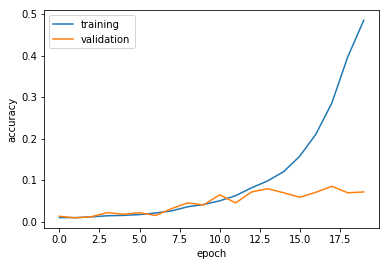

In [30]:
plt.plot(vgg_history.history['acc'], label='training')
plt.plot(vgg_history.history['val_acc'], label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

Out training accuracy is imporving fast while the va;lidation accuracy lags behind. It might be s sign of the overfitting.

In [31]:
y_pred_proba = vgg_model.predict(X_test)
y_pred_test = np.zeros(y_pred_proba.shape)
y_pred_test[y_pred_proba > 0.5] = 1

In [33]:
print(classification_report(y_test, y_pred_test, target_names = binarizer.classes_))

                                precision    recall  f1-score   support

                 affenpinscher       0.50      0.12      0.20         8
                  afghan_hound       0.20      0.08      0.12        12
           african_hunting_dog       0.00      0.00      0.00         9
                      airedale       0.00      0.00      0.00        11
american_staffordshire_terrier       0.00      0.00      0.00         7
                   appenzeller       0.00      0.00      0.00         8
            australian_terrier       0.00      0.00      0.00        10
                       basenji       0.00      0.00      0.00        11
                        basset       0.00      0.00      0.00         8
                        beagle       0.00      0.00      0.00        11
            bedlington_terrier       0.14      0.11      0.12         9
          bernese_mountain_dog       0.00      0.00      0.00        11
       black-and-tan_coonhound       0.00      0.00      0.00  

C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


So far the model does not perform, only a few of the breeds are recognized in the validation set and even those are not recognized well.

We need to give our model more data. Lets generate images by rotating / shifting the originals.

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

In [19]:
test_datagen = ImageDataGenerator()
test_datagen.fit(X_test)

In [39]:
batch_size = 128
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [40]:
vgg_history1 = vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=9199/batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=1023/batch_size,
    callbacks = [earlyStopping, checkpoint],
    verbose = 1
)

Epoch 1/100
72/71 [==============================] - 273s - loss: 4.6577 - acc: 0.0295 - val_loss: 4.2756 - val_acc: 0.0606
Epoch 2/100
72/71 [==============================] - 274s - loss: 4.3462 - acc: 0.0455 - val_loss: 4.1411 - val_acc: 0.0635
Epoch 3/100
72/71 [==============================] - 278s - loss: 4.2703 - acc: 0.0515 - val_loss: 4.1124 - val_acc: 0.0733
Epoch 4/100
72/71 [==============================] - 278s - loss: 4.2123 - acc: 0.0592 - val_loss: 4.0484 - val_acc: 0.0831
Epoch 5/100
72/71 [==============================] - 278s - loss: 4.1803 - acc: 0.0630 - val_loss: 4.1196 - val_acc: 0.0635
Epoch 6/100
72/71 [==============================] - 281s - loss: 4.1386 - acc: 0.0672 - val_loss: 4.0932 - val_acc: 0.0772
Epoch 7/100
72/71 [==============================] - 278s - loss: 4.1123 - acc: 0.0654 - val_loss: 4.0640 - val_acc: 0.0714
Epoch 8/100
72/71 [==============================] - 280s - loss: 4.0684 - acc: 0.0730 - val_loss: 4.0231 - val_acc: 0.0821
Epoch 9/

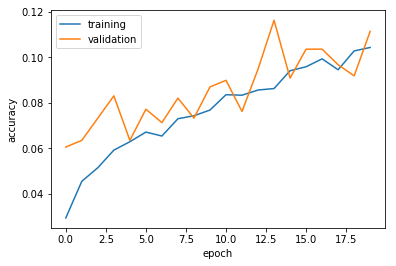

In [41]:
plt.plot(vgg_history1.history['acc'], label='training')
plt.plot(vgg_history1.history['val_acc'], label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

This look much better, both training and validation accuracy are going up. We are going to continue training.

In [26]:
batch_size = 128
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

Training with a bit more patience.

In [23]:
vgg_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [24]:
earlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience = 10, verbose = 0, mode = 'auto')
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [27]:
vgg_history2 = vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=9199/batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=1023/batch_size,
    callbacks = [earlyStopping, checkpoint],
    verbose = 1
)

Epoch 1/100
72/71 [==============================] - 412s - loss: 3.6214 - acc: 0.1265 - val_loss: 3.9083 - val_acc: 0.1065
Epoch 2/100
72/71 [==============================] - 405s - loss: 3.5227 - acc: 0.1406 - val_loss: 3.9281 - val_acc: 0.1144
Epoch 3/100
72/71 [==============================] - 347s - loss: 3.5064 - acc: 0.1504 - val_loss: 3.8851 - val_acc: 0.1222
Epoch 4/100
72/71 [==============================] - 342s - loss: 3.4845 - acc: 0.1506 - val_loss: 3.8534 - val_acc: 0.1281
Epoch 5/100
72/71 [==============================] - 278s - loss: 3.4597 - acc: 0.1472 - val_loss: 3.9341 - val_acc: 0.1173
Epoch 6/100
72/71 [==============================] - 341s - loss: 3.4136 - acc: 0.1549 - val_loss: 3.8981 - val_acc: 0.1339
Epoch 7/100
72/71 [==============================] - 277s - loss: 3.3929 - acc: 0.1655 - val_loss: 3.8040 - val_acc: 0.1261
Epoch 8/100
72/71 [==============================] - 279s - loss: 3.3372 - acc: 0.1684 - val_loss: 3.7968 - val_acc: 0.1339
Epoch 9/

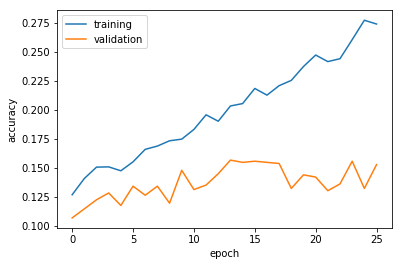

In [28]:
plt.plot(vgg_history2.history['acc'], label='training')
plt.plot(vgg_history2.history['val_acc'], label='validation')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

Prepare data for the Kaggle submission

In [18]:
test_ids = [ os.path.splitext(f)[0] for f in listdir('test') if isfile(join('test', f))]
test_features = load_images('test', test_ids, 224, 224)
print('Features shape ', test_features.shape)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 22 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 13 tasks to complete...
Waiting for 12 tasks to complete...
Waiting for 6 tasks to complete...
Waiting for 4 tasks to complete...
Finished loading images...
Features shape  (10357, 224, 224, 3)


In [19]:
test_features_mean = np.mean(test_features, axis=(0))
print(test_features_mean.shape)

(224, 224, 3)


In [20]:
test_features_centered = test_features - test_features_mean

In [21]:
y_pred_proba = vgg_model.predict(test_features_centered)

In [28]:
output_df = pd.DataFrame(y_pred_proba)
output_df.columns = binarizer.classes_
output_df.insert(loc=0, column='id', value=test_ids)
output_df.reset_index(drop=True, inplace=True)
output_df.to_csv('vgg16_pred.csv',  index=False, float_format='%.7f')